In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### Mise en forme de la data frame "df_mlg" pour le mlg

In [2]:
data = pd.read_csv("DataEnergy-Student.csv")
n=data.shape[0]
p=data.shape[1]


In [3]:
data_mlg = data.copy(deep=True)
data_mlg["Energy.efficiency.bis"] = ((data_mlg["Energy.efficiency"] == 'A') | (data_mlg["Energy.efficiency"] == 'B')).astype(int)
data_mlg.drop(columns=["Energy.efficiency","Roof.area"],inplace = True)

In [4]:
dataDum=pd.get_dummies(data_mlg[["Overall.height","orientation","Glazing.area.distr","Energy.efficiency.bis"]])
dataQuant=data_mlg[["Energy","Relative.compactness","Surface.area","Wall.area","Glazing.area"]]
df_mlg=pd.concat([dataDum,dataQuant],axis=1)

In [5]:
# variable à expliquer binaire
Yb=df_mlg["Energy.efficiency.bis"]
Yr=df_mlg["Energy"]
df_mlg.drop(columns=["Energy.efficiency.bis","Energy"],inplace=True)

###  Répartitions des données en données apprentissage et test.

In [6]:
# 75% en apprentissage et 25% en test.
X_train,X_test,Yb_train,Yb_test=train_test_split(df_mlg,Yb,test_size = 0.25,random_state=11)
X_train,X_test,Yr_train,Yr_test=train_test_split(df_mlg,Yr,test_size=0.25,random_state=11)

In [7]:
from sklearn.preprocessing import StandardScaler  
# L'algorithme ds réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# Meme transformation sur le test
X_test = scaler.transform(X_test)

In [8]:
type(X_train)

numpy.ndarray

## Régression Logistique

In [9]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[1,1.2,1.5,1.7,2,3,4]}]
logit = GridSearchCV(LogisticRegression(penalty="l1"), param_grid = param)
logitOpt=logit.fit(X_train, Yb_train)  # GridSearchCV est lui même un estimateur
# paramètre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.086806, Meilleur paramètre = {'C': 2}


#### Erreur sur l'échantillon test 

In [10]:
1-logitOpt.score(X_test, Yb_test)

0.09375

##### Prévision sur l'ensemble test

In [11]:
y_chap = logitOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

Energy.efficiency.bis    0   1
row_0                         
0                      105   5
1                       13  69


##### Interprétation des coéfficients (importance) et variables retenues

In [12]:
# Coefficients
logitLasso=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef=logitLasso.fit(X_train,Yb_train).coef_
print(logitCoef[0])

[-3.5942124   0.2348129   0.22997142  0.         -0.16103242  0.02530134
  0.68927729  0.32729804 -0.88553905 -1.04753857]


In [13]:
coef = pd.Series(logitCoef[0], index = df_mlg.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 9 variables et en supprime 1


Text(0.5, 1.0, 'Coefficients du modèle lasso')

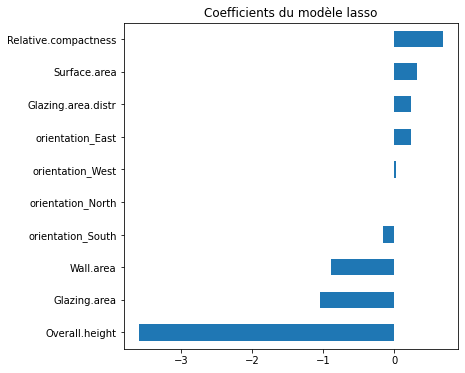

In [14]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

## Optimal Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param)
treeOpt=tree.fit(X_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

Meilleur score = 0.100694, Meilleur paramètre = {'max_depth': 2}


In [16]:
# Estimation de l'erreur de prévision
1-treeOpt.score(X_test,Yb_test)

0.08854166666666663

In [17]:
# prévision de l'échantillon test
y_chap = treeOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

Energy.efficiency.bis    0   1
row_0                         
0                      101   0
1                       17  74


In [18]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import pydotplus
# You have to run : sudo apt-get install graphviz
treeG=DecisionTreeClassifier(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(X_train,Yb_train)
dot_data = StringIO() 
export_graphviz(treeG, out_file=dot_data) 
graph=pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("treeOpt.png")

True

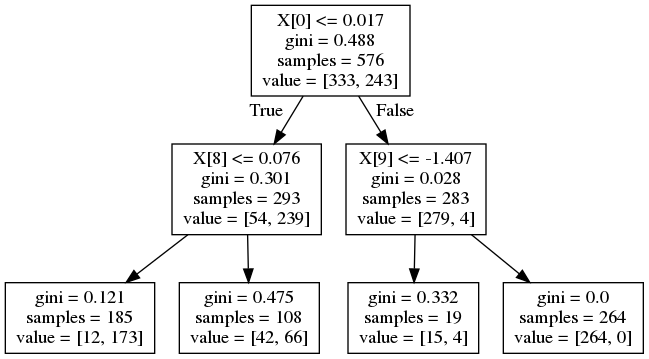

In [19]:
from IPython.display import Image
Image(filename='treeOpt.png')

## Random Forest 

In [20]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres


/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),
        param)
rfOpt=rf.fit(X_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.083333, Meilleur paramètre = {'max_features': 5}


In [22]:
# erreur de prévision sur le test
1-rfOpt.score(X_test,Yb_test)

0.05208333333333337

In [23]:
# prévision
y_chap = rfOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

Energy.efficiency.bis    0   1
row_0                         
0                      112   4
1                        6  70


In [24]:
rf= RandomForestClassifier(n_estimators=100,max_features=2)
rfFit=rf.fit(X_train, Yb_train)
# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(df_mlg.columns[indices[f]], importances[indices[f]])

Relative.compactness 0.2689172497164309
Overall.height 0.249493499131571
Surface.area 0.21948667927142254
Wall.area 0.12931825806831634
Glazing.area 0.07849006434330025
Glazing.area.distr 0.031012649493891625
orientation_South 0.007147144266368488
orientation_East 0.005934080443495257
orientation_North 0.005549346099147609
orientation_West 0.004651029166055976


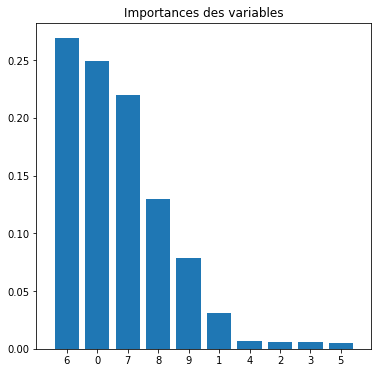

In [25]:
# Graphe des importances
plt.figure()
plt.title("Importances des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Comparaison des méthodes

In [26]:
from sklearn.metrics import roc_curve
listMethod=[["RF",rfOpt],["Tree",treeOpt],["Logit",logitOpt]]

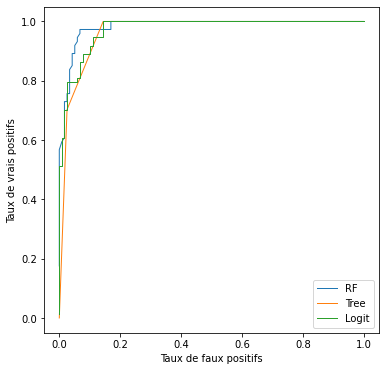

In [27]:
for method in enumerate(listMethod):
    probas_ = method[1][1].fit(X_train, Yb_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Yb_test, probas_[:,1])
    plt.plot(fpr, tpr, lw=1,label="%s"%method[1][0])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc="best")
plt.show()

## Regression with given thresholds

In [28]:
from sklearn.tree import DecisionTreeRegressor
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
treer= GridSearchCV(DecisionTreeRegressor(),param)
treeOptr=treer.fit(X_train, Yr_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

Meilleur score = 0.102431, Meilleur paramètre = {'max_depth': 2}


In [29]:
# Estimation de l'erreur de prévision
1-treeOptr.score(X_test,Yr_test)

0.09008524061553858

In [30]:
# prévision de l'échantillon test
y_chap = treeOptr.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap>35,Yr_test>35)
print(table)

Energy  False  True 
row_0               
False      74      7
True        0    111


In [31]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
#import pydotplus
# You have to run : sudo apt-get install graphviz
treeG=DecisionTreeRegressor(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(X_train,Yr_train)
dot_data = StringIO() 
export_graphviz(treeG, out_file=dot_data) 
graph=pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("treeOpt.png")

True

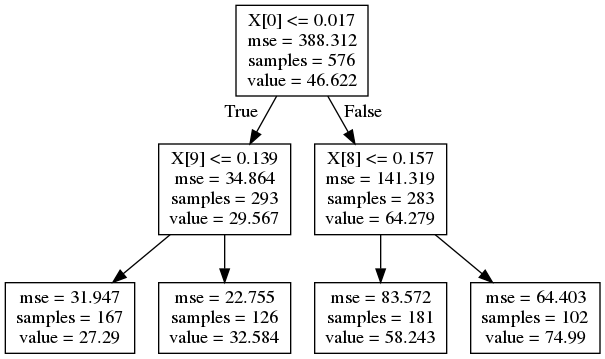

In [32]:
from IPython.display import Image
Image(filename='treeOpt.png')